### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

In [1]:
import torch
import torch.nn as nn

### Stacking layer with `nn.Sequential`

In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(nn.Linear(28*28, 512),
                                          nn.ReLU(),
                                          nn.Linear(512, 512),
                                          nn.ReLU(),
                                          nn.Linear(512, 10))

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits


model = SimpleNN()

### Model's prediction of an instance

In [3]:
x = torch.rand(28, 28, 1)

x_us = x.unsqueeze(axis=0)
print(x_us.shape)

model(x_us)

torch.Size([1, 28, 28, 1])


tensor([[-0.0472,  0.1399, -0.0827, -0.0195,  0.0013,  0.0763, -0.1255,  0.0047,
          0.0243,  0.0003]], grad_fn=<AddmmBackward0>)

# Image classification with LeNet-5

![lenet5](http://d2l.ai/_images/lenet.svg)

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

In [5]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 128 # 1 Batch จะมี 128 รูป
NUM_EPOCHS = 5 # วนใหม่ 5 รอบ

# Classification
NUM_CLASSES = 10 # เราต้องการ Classify 10 Class

# CIFAR10 dataset

Classify (32x32x3) images into 10 classes

Here, `train_dataset` and `val_dataset` are `(image, label)` generators

In [6]:
train_dataset = datasets.CIFAR10(root='data',
                                 train=True,
                                 transform=transforms.ToTensor(),
                                 download=True)

val_dataset = datasets.CIFAR10(root='data',
                                train=False,
                                transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:03<00:00, 44223349.03it/s]


Extracting data/cifar-10-python.tar.gz to data


Look at an image in the dataset

torch.Size([3, 32, 32])


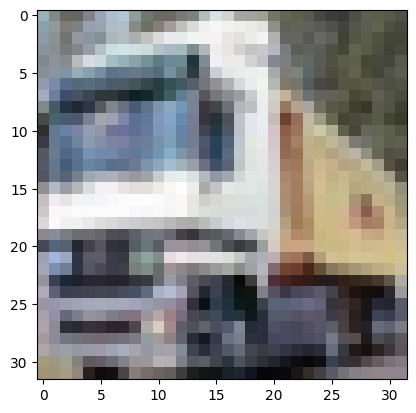

In [7]:
image, label = train_dataset[1] # ดูข้อมูลตัวที่ 1 บน Training set

print(image.shape)

plt.imshow(image.permute(1, 2, 0))

# Data augmentation

![augmentation](https://miro.medium.com/max/700/0*LR1ZQucYW96prDte)

See more transformations in [Pytorch documentation](https://pytorch.org/vision/0.9/transforms.html)

In [8]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # การ Flip แบบสุ่ม
                                      transforms.RandomResizedCrop((32, 32), # การย่อ/ขยายขนาด แล้ว Crop แบบสุ่ม
                                                                   scale=(0.7,0.8),
                                                                   ratio=(0.6,0.7)),
                                     transforms.ToTensor()
                                     ])

train_dataset = datasets.CIFAR10(root='data',
                                 train=True,
                                 transform=train_transform,
                                 download=True)

val_dataset = datasets.CIFAR10(root='data',
                                train=False,
                                transform=transforms.ToTensor())

Files already downloaded and verified


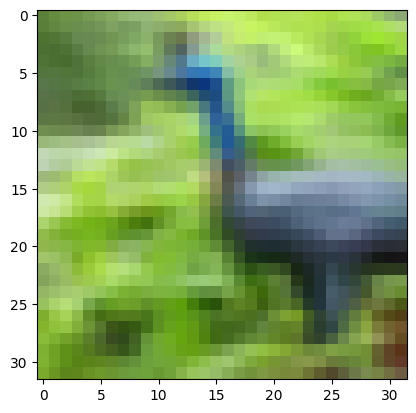

In [9]:
image, labels = train_dataset[6]
plt.imshow(image.permute(1,2,0))

Use `DataLoader` to split the dataset into minibatches.

In [10]:
# เปลี่ยนเป็น DataLoader คือ Load ข้อมูลเข้าโมเดลของเรา
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=2,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=2,
                         shuffle=False) # ไม่ต้อง Shuffle เนื่องจากแค่จะใช้ทดสอบโมเดลอย่างเดียว


Check the size of each minibatch

In [11]:
for images, labels in train_loader:
  print(images.shape)
  break

torch.Size([128, 3, 32, 32])


# LeNet5

![lenet5](http://d2l.ai/_images/lenet.svg)

In [12]:
class LeNet5(nn.Module):

    def __init__(self, num_classes):
        super(LeNet5, self).__init__()

        self.num_classes = num_classes

        # Feature Extraction
        # Sequential เป็น Method ในการรวม Layer ต่าง ๆ เข้าไว้ด้วยกัน
        self.features = nn.Sequential(
            # Input shape = 28 x 28 x 3
            nn.Conv2d(in_channels=3, out_channels=6*3, kernel_size=5),
            # Output shape = 28 - (5 - 1) = 24
            nn.Dropout(0.2),
            nn.BatchNorm2d(6*3),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=3),
            # shape = 24/3 = 8
            nn.Conv2d(in_channels=6*3, out_channels=16*3, kernel_size=5),
            # shape = 8 - (5 - 1) = 4
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
            # shape = 4/2 = 2
        )
        # Feature Classification
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(48*2*2, 3*120), # เปลี่ยนจาก 16*3*2*2
            nn.Tanh(),
            nn.Linear(3*120, 3*84),
            nn.Tanh(),
            nn.Linear(3*84, self.num_classes)
        )


    def forward(self, x):
      x = self.features(x) # Feature Extraction
      print(x.shape)
      logits = self.classifier(x) # Feature Classification
      return logits

model = LeNet5(NUM_CLASSES)

Apply the model on an image

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam ย่อมาจาก Adaptive Moment Estimation

In [14]:
# ฟังก์ชันในการ Train Model
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# ฟังก์ชันในการ Test Model
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # ไม่มีการคำนวณ Gradient ในส่วน Test Model
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(val_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
torch.Size([128, 48, 2, 2])
loss: 2.306530  [    0/50000]
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.Size([128, 48, 2, 2])
torch.

In [ ]:
# โค้ดการทำนาย
image, label = train_dataset[1]

print("Label =", label) # Label ของจริง

print("Prediction =", model(image.unsqueeze(axis=0))) # Output ที่ได้ กลุ่มที่มี Probability สูงสุด คือกลุ่มที่มีเลขสูงสุดจะ Classify ให้อยู่กลุ่ม 9

Label = 9
torch.Size([1, 48, 2, 2])
Prediction = tensor([[ 0.9041,  0.5976,  0.4386, -1.6332, -1.9310, -1.4876, -1.8746, -0.0559,
          0.9990,  3.8611]], grad_fn=<AddmmBackward0>)


# Exercise

1. Modify the model to have at least **3 convolution layers** and **3 Max-pooling layers** (and possibly some batch normalization and some dropout layers)
2. Change the activation function from Tanh to other functions (see [Pytorch documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity))
3. Your model must have more than 69% accuracy on validation set.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
class ImprovedLeNet5(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedLeNet5, self).__init__()

        self.num_classes = num_classes

        # Feature Extraction
        self.features = nn.Sequential( # เพิ่ม Convolution Layer และ Max-pooling Layer (ต้องคำนวณ Input และ Output ใหม่)
            # Input shape = 32 x 32 x 3
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # Output shape = 28 x 28 x 18
            nn.BatchNorm2d(32),
            nn.ReLU(), # เปลี่ยน Activation Function ทั้งหมดเป็น ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape = 14 x 14 x 18
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            # Output shape = 10 x 10 x 48
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape = 5 x 5 x 48
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # Output shape = 3 x 3 x 96
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output shape = 1 x 1 x 96
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )

        # Feature Classification
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # เพิ่ม Layer dropout
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)  # Feature Extraction
        logits = self.classifier(x)  # Feature Classification
        return logits

model = ImprovedLeNet5(NUM_CLASSES)

In [22]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 12  # เพิ่มจำนวนรอบ epochs เป็น 12

# Optimizer ใช้ Adam (Adaptive Moment Estimation)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning Rate Scheduler เพื่อให้การ Train Model คอยมีการ update ค่า Learning Rate ที่เหมาะสมในแต่ละรอบ epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [23]:
# Training Loop
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(val_loader, model, loss_fn)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 2.336399  [    0/50000]
loss: 1.703479  [12800/50000]
loss: 1.430480  [25600/50000]
loss: 1.502946  [38400/50000]
Test Error: 
 Accuracy: 50.5%, Avg loss: 1.352711 

Epoch 2
-------------------------------
loss: 1.325178  [    0/50000]
loss: 1.316288  [12800/50000]
loss: 1.283874  [25600/50000]
loss: 1.103976  [38400/50000]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.189632 

Epoch 3
-------------------------------
loss: 1.013899  [    0/50000]
loss: 1.218700  [12800/50000]
loss: 1.135787  [25600/50000]
loss: 1.115214  [38400/50000]
Test Error: 
 Accuracy: 60.4%, Avg loss: 1.109161 

Epoch 4
-------------------------------
loss: 1.080722  [    0/50000]
loss: 0.972559  [12800/50000]
loss: 1.017065  [25600/50000]
loss: 0.815061  [38400/50000]
Test Error: 
 Accuracy: 63.0%, Avg loss: 1.051684 

Epoch 5
-------------------------------
loss: 1.070425  [    0/50000]
loss: 0.872652  [12800/50000]
loss: 1.010184  [25600/50000]
loss: 0.933939  [38400

**Model ที่ได้หลังจากการ Train มีค่า Accuracy บน Validation Set เป็น 70.1%**